In [2]:
import os
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
def initialize_firebase():
    """
    Initialize Firebase with fallback credential paths and return a Firestore client.
    """
    # Define your credential paths
    vm_path = r"C:\MasterThesis\Keys.json"
    primary_path = r"C:\Users\sajad\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"
    fallback_path = r"C:\Users\Benja\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"

    if not firebase_admin._apps:
        cred = None
        if os.path.exists(vm_path):
            cred = credentials.Certificate(vm_path)
        elif os.path.exists(primary_path):
            cred = credentials.Certificate(primary_path)
        elif os.path.exists(fallback_path):
            cred = credentials.Certificate(fallback_path)
        else:
            raise FileNotFoundError("Firebase credentials file not found in any of the specified paths.")
        
        firebase_admin.initialize_app(cred)

    return firestore.client()

db = initialize_firebase()


# 🧹 Extract Data from Firestore
def fetch_model_recommendations():
    try:
        collection_ref = db.collection("model_recommendations")
        docs = collection_ref.stream()
        
        data = []
        for doc in docs:
            doc_data = doc.to_dict()
            data.append(doc_data)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(data)
        print("✅ Data fetched successfully!")
        return df
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_model_recommendations()

# Save the data to a CSV file for backup
df.to_csv("model_recommendations.csv", index=False)
print(df.head())

✅ Data fetched successfully!
   is_correct  latest_close  experiment_day stock_ticker  \
0        True    222.354996               0         AAPL   
1       False     80.959999               0          NVO   
2       False    444.839996               0         MSFT   
3        True    222.520004               0         AAPL   
4        True    146.774002               0         NVDA   

                                   sentiment_summary recommendation_detail  \
0  {'neutral': 3.9237, 'negative': 6.7564, 'posit...                         
1  {'neutral': 6.4306, 'negative': 4.4333, 'posit...                         
2  {'neutral': 5.1978, 'negative': 17.39600000000...                         
3  {'neutral': 11.7711, 'negative': 20.2692, 'pos...                         
4  {'neutral': 5.1636, 'positive': 19.1582, 'nega...                         

                    timestamp aggregator_recommendation  previous_close  \
0  2025-01-22T18:25:02.957188                      Sell      222.6

# Quantitative analysis

C:\Users\sajad\AppData\Local\Temp\ipykernel_19564\3315092669.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
c:\Users\sajad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\sajad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_g

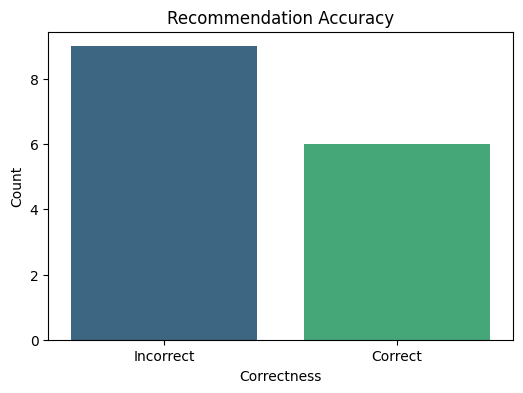

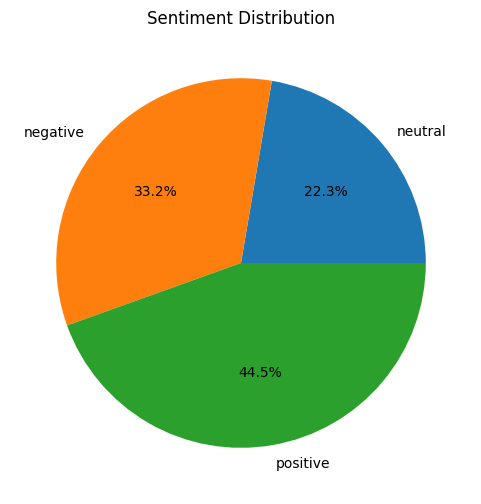

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (if not already loaded)
df = pd.read_csv("model_recommendations.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Analysis: Recommendation Accuracy
accuracy_counts = df['is_correct'].value_counts()

# Visualize Recommendation Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
plt.title("Recommendation Accuracy")
plt.xlabel("Correctness")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.show()

# Sentiment Summary Distribution
sentiments = df['sentiment_summary'].apply(eval)  # Convert string to dictionary
sentiment_df = pd.json_normalize(sentiments)

# Plot Sentiment Distribution
sentiment_df.sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Distribution")
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Feature Engineering
df['price_change'] = (df['latest_close'] - df['previous_close']) / df['previous_close'] * 100
df['sentiment_score'] = df['sentiment_summary'].apply(lambda x: eval(x)['positive'] - eval(x)['negative'])

# Prepare Dataset for Machine Learning
features = ['price_change', 'sentiment_score']
X = df[features]
y = df['is_correct']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.75      0.75      0.75         4
        True       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.38      0.38      0.38         5
weighted avg       0.60      0.60      0.60         5

[[3 1]
 [1 0]]


C:\Users\sajad\AppData\Local\Temp\ipykernel_19564\1103881699.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=importances, palette="viridis")
c:\Users\sajad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\sajad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


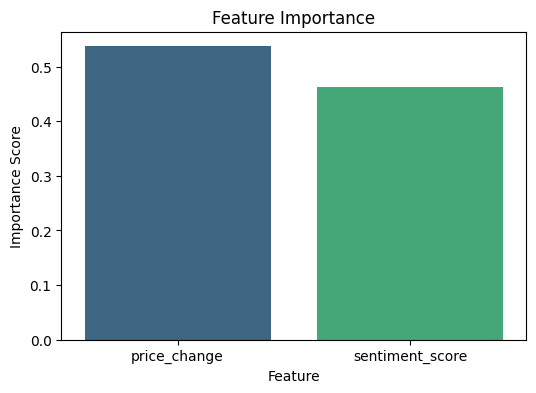

In [5]:
# Feature Importance
importances = clf.feature_importances_
plt.figure(figsize=(6, 4))
sns.barplot(x=features, y=importances, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()


In [6]:
# Incorrect Recommendations
incorrect_cases = df[df['is_correct'] == False]
print(incorrect_cases[['aggregator_recommendation', 'sentiment_summary', 'price_change']].head())


  aggregator_recommendation  \
1                       Buy   
2                      Sell   
5                       Buy   
6                       Buy   
8                      Sell   

                                   sentiment_summary  price_change  
1  {'neutral': 6.4306, 'negative': 4.4333, 'posit...     -0.086387  
2  {'neutral': 5.1978, 'negative': 17.39600000000...      3.813301  
5  {'negative': 3.6002000000000005, 'positive': 9...     -0.881676  
6  {'neutral': 11.297699999999999, 'negative': 10...     -0.860706  
8  {'neutral': 7.7967, 'negative': 26.09399999999...      3.823806  
   aggregator_recommendation  \
0                       Sell   
3                       Sell   
4                        Buy   
7                       Sell   
12                       Buy   

                                    sentiment_summary  price_change  
0   {'neutral': 3.9237, 'negative': 6.7564, 'posit...     -0.128011  
3   {'neutral': 11.7711, 'negative': 20.2692, 'pos...     -0.05389

In [ ]:
# Correct Recommendations
correct_cases = df[df['is_correct'] == True]
print(correct_cases[['aggregator_recommendation', 'sentiment_summary', 'price_change']].head())

In [9]:
import pandas as pd
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Dataset Profiling Report", explorative=True)
profile.to_file("dataset_profile.html")


# Display the report in Jupyter Notebook (optional)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]